# Article - Clinical Neurophisiology - Final model

In [5]:
import pandas as pd

In [6]:
df_bands = pd.read_csv('../../dev/own_data/190902_grid_pipeline/features/bands.csv')
df_env_alpha = pd.read_csv('../../dev/own_data/190902_grid_pipeline/features/env_alpha.csv')
df_env_beta = pd.read_csv('../../dev/own_data/190902_grid_pipeline/features/env_beta.csv')
df_coh_alpha = pd.read_csv('../../dev/own_data/190902_grid_pipeline/features/coh_alpha.csv')
df_coh_beta = pd.read_csv('../../dev/own_data/190902_grid_pipeline/features/coh_beta.csv')

In [7]:
out_path = '../../dev/own_data/190908_for_article'

models.py

In [28]:
from os.path import exists, join
from os import mkdir, remove, listdir

import pandas as pd
import numpy as np

from tqdm import trange

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

def create_or_append(df, path):
    if exists(path):
        df.to_csv(path, mode='a', index=False, header=False)
    else:
        df.to_csv(path, index=False)


def run_exper(X, y, custom_model, outliers_rate=0.1, n_expers=100):

    custom_model.outliers_rate = outliers_rate

    if type(y) == type(pd.Series()):
        y = y.values

    roc_aucs = []
    accs = []
    for _ in range(n_expers):
        random_state = np.random.choice(np.arange(10000))
        custom_model.run_cv(X, y, random_state=random_state)
        roc_auc = custom_model.get_roc_auc()
        acc = custom_model.get_accuracy()
        roc_aucs.append(roc_auc)
        accs.append(acc)
    roc_aucs = np.array(roc_aucs)
    accs = np.array(accs)
    return {
        'roc_auc_mean': roc_aucs.mean(),
        'roc_auc_std': roc_aucs.std(),
        'acc_mean': accs.mean(),
        'acc_std': accs.std()
    }


class BaseModel(object):
    """Aim of this class is to provide fast calculation
    of results and metrics that are needed for each model
    """

    def __init__(self, cv='10fold', *args, **kwargs):
        """
        Args:
            X: 2d numpy or pd.DataFrame
            y: 1d numpy array or pd.Series
            model: sklearn-kind model with predict_proba function
            to_drop: idx to drop during train stage
            cv: loo, 5fold or 10fold
        """

        self.y_pred = None
        self.y_true = None
        self.cv = cv

    def _get_cv(self, random_state=42):

        if self.cv == 'loo':
            return LeaveOneOut()
        elif self.cv == '5fold':
            return KFold(n_splits=5, shuffle=True, random_state=random_state)
        elif self.cv == '10fold':
            return KFold(n_splits=10, shuffle=True, random_state=random_state)
        else:
            raise ValueError('wrong value of the cv parameter')

    def run_cv(self, X, y, to_drop=[], random_state=42):
        raise NotImplementedError

    def _set_random_state(self, random_state):
        raise NotImplementedError

    def get_roc_auc(self):
        return roc_auc_score(self.y_true, self.y_pred)

    def get_accuracy(self):
        return accuracy_score(self.y_true, self.y_pred > 0.5)

    def get_outliers_idx(self, n_outliers=5):
        outliers_idx = (
            np.argsort(
                np.abs(self.y_pred - self.y_true))
            [::-1]
            [:n_outliers])
        return outliers_idx

    def get_ypred_df(self):
        df = pd.DataFrame({'y_true': self.y_true, 'y_pred': self.y_pred})
        return df


class RegularModel(BaseModel):
    def __init__(self, model, *args, **kwargs):
        super(RegularModel, self).__init__(*args, **kwargs)
        self.model = model

    def run_cv(self, X, y, to_drop=[], random_state=42):
        self.model.set_params(random_state=random_state)
        self.y_pred = np.zeros(shape=y.shape)
        self.y_true = y
        cv = self._get_cv(random_state=random_state)
        for train_idx, test_idx in cv.split(X, y):
            if len(to_drop):
                train_idx = [idx for idx in train_idx if idx not in to_drop]
            self.model.fit(X[train_idx, :], y[train_idx])
            self.y_pred[test_idx] = self.model.predict_proba(X[test_idx, :])[:, 1]


class LRModel(RegularModel):
    def __init__(self, *args, **kwargs):
        model = LogisticRegression(solver='liblinear')
        super(LRModel, self).__init__(model=model, *args, **kwargs)

    def run_cv(self, X, y, *args, **kwargs):
        X = StandardScaler().fit_transform(X)
        super(LRModel, self).run_cv(X, y, *args, **kwargs)

In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve


def plot_roc_curve(y_true, y_pred, title=None, auc=None, save_path=None):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    
    if auc is None:
        auc = roc_auc_score(y_true, y_pred)
        
    if title is None:
        title = 'Receiver operating characteristic'

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (average area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    if save_path:
        plt.savefig(save_path, transparent=True, dpi=150)


def save_samples(out_path, exper_name, X, y, custom_model, random_state=42):
    # save to sample predictions
    random_state = np.random.choice(np.arange(10000))
    custom_model.run_cv(X, y, random_state=random_state)
    prediction_df = pd.DataFrame({'y_pred': custom_model.y_pred, 'y_true': custom_model.y_true})
    prediction_df.to_csv(join(out_path, exper_name + '.csv'), index=False)
    return prediction_df

## Baseline all features

In [10]:
def merge_dfs(dfs):

    res_df = None
    
    for i, df in enumerate(dfs):
        
        df = df.copy()
        del df['dataset']
        
        if i == 0:
            res_df = df
        else:
            del df['target']
            res_df = res_df.merge(df, on='fn')
            
    return res_df

In [11]:
df_all_feats = merge_dfs([
    df_env_alpha,
    df_env_beta,
    df_coh_alpha,
    df_coh_beta,
    df_bands
])

In [12]:
features = [col for col in df_all_feats.columns if col not in ['dataset', 'fn', 'target']]
X = df_all_feats[features].fillna(0).values
y = df_all_feats['target'].values
model = LRModel()

In [13]:
res = run_exper(X, y, model)

In [14]:
res

{'roc_auc_mean': 0.7580555555555556,
 'roc_auc_std': 0.01966604344989002,
 'acc_mean': 0.7356179775280899,
 'acc_std': 0.0276803858743198}

In [20]:
baseline_all_feats_pred = save_samples(out_path, 'baseline_all_feats', X, y, model, random_state=42)

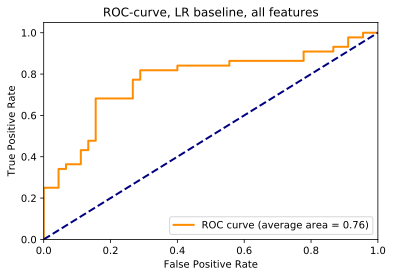

In [21]:
plot_roc_curve(
    baseline_all_feats_pred['y_true'], 
    baseline_all_feats_pred['y_pred'], 
    auc=0.76, 
    title='ROC-curve, LR baseline, all features', 
    save_path='roc_all_feats.png')

## Feature removal

In [22]:
import operator
from tqdm import tqdm

In [39]:
def select_features(df, features, custom_model):
    X = df[features].fillna(0).values
    y = df['target'].values

    X_sc = StandardScaler().fit_transform(X)
    lr = LogisticRegression(solver='liblinear')
    lr.fit(X_sc, y)
    weights = [(f, np.abs(w)) for f, w in zip(features, lr.coef_[0])]
    weights = sorted(weights, key=operator.itemgetter(1))
    features = list(list(zip(*weights))[0])[::-1]

    new_features = []

    best_score = None

    print('Feature selection. Step 1')

    for f in tqdm(features):

        cur_features = new_features + [f]

        X = df[cur_features].fillna(0).values
        cur_score = run_exper(X, y, custom_model, n_expers=100)['roc_auc_mean']

        if best_score is None or (cur_score - best_score) > 0.001:
            new_features = cur_features
            best_score = cur_score

    print('Feature selection. Step 2')
    features = new_features.copy()

    for f in tqdm(features):
        cur_features = [_f for _f in new_features if _f != f]

        X = df[cur_features].fillna(0).values
        cur_score = run_exper(X, y, custom_model, n_expers=100)['roc_auc_mean']

        if best_score is None or (cur_score - best_score) > 0.001:
            new_features = cur_features
            best_score = cur_score

    return new_features

In [40]:
features = [col for col in df_all_feats.columns if col not in ['dataset', 'fn', 'target']]

In [41]:
features_filtered = select_features(df_all_feats, features, LRModel())

  0%|          | 0/420 [00:00<?, ?it/s]

Feature selection. Step 1


  0%|          | 0/29 [00:00<?, ?it/s]

Feature selection. Step 2


100%|██████████| 29/29 [00:18<00:00,  1.50it/s]


In [42]:
X = df_all_feats[features_filtered].fillna(0).values
y = df_all_feats['target'].values
model = LRModel()

In [43]:
run_exper(X, y, model)

{'roc_auc_mean': 0.9793232323232323,
 'roc_auc_std': 0.004249525081947373,
 'acc_mean': 0.9530337078651686,
 'acc_std': 0.016078019601423226}

In [44]:
len(features_filtered)

26

In [45]:
selected_features_pred = save_samples(out_path, 'selected_features_pred', X, y, model, random_state=100)

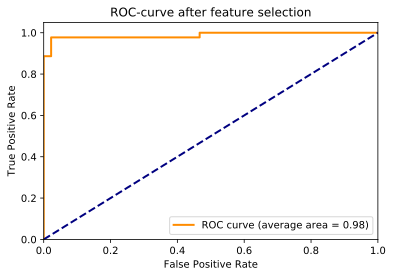

In [46]:
plot_roc_curve(
    selected_features_pred['y_true'], 
    selected_features_pred['y_pred'], 
    auc=0.98, 
    title='ROC-curve after feature selection', 
    save_path='roc_after_feat_sel.png')

In [47]:
features_filtered

['coh_beta_f7_f3',
 'env_alpha_f3_t5',
 'coh_beta_f3_f4',
 'coh_alpha_t4_f8',
 'env_alpha_t6_f3',
 't5_gamma',
 'env_alpha_c4_o2',
 'coh_beta_o1_o2',
 'env_alpha_f8_f3',
 'p3_gamma',
 'f3_gamma',
 'coh_beta_f8_o2',
 'env_alpha_p4_c4',
 'coh_alpha_t3_o2',
 'env_alpha_c3_t5',
 'coh_beta_t3_c3',
 'coh_beta_t4_o1',
 'coh_beta_t3_p3',
 'env_alpha_c4_p3',
 'env_alpha_t4_f7',
 'coh_beta_f7_p3',
 'coh_beta_t4_t5',
 'coh_alpha_t6_t3',
 'f8_alpha',
 'coh_beta_o2_p3',
 'coh_alpha_f7_f4']

## Predictions exploration

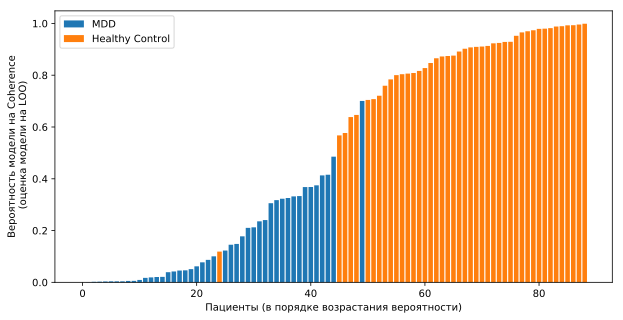

In [61]:
selected_features_pred_sorted = selected_features_pred.sort_values('y_pred')
scores = selected_features_pred_sorted['y_pred']
col1 = sns.color_palette()[0]
col2 = sns.color_palette()[1]
colors = [col2 if is_pat else col1 for is_pat in selected_features_pred_sorted['y_true']]
idx = np.arange(len(selected_features_pred_sorted))

plt.figure(figsize=[10, 5])
plt.xlabel('Пациенты (в порядке возрастания вероятности)')
plt.ylabel('Вероятность модели на Coherence\n (оценка модели на LOO)')
bars = plt.bar(idx, scores, color=colors)

# !!! select colors by hands
plt.legend([bars[0], bars[-1]], ['MDD', 'Healthy Control'])

# plt.savefig('own_data/181031_score_bars_8min_coh.png', dpi=300, transparent=True, bbox_inches='tight')

## PCA

In [ ]:
df_all_feats[features_filtered]

In [62]:
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE, Isomap

In [63]:
X_pca = PCA(n_components=3).fit_transform(df_all_feats[features_filtered].fillna(0))

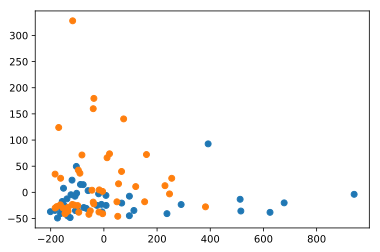

In [67]:
colors = [col2 if is_pat else col1 for is_pat in y]
plt.scatter(X_pca[:, 0], X_pca[:, 1], color=colors)

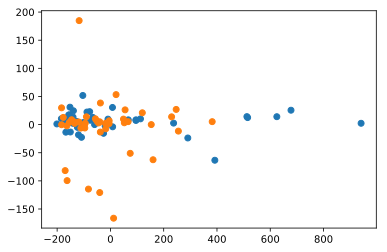

In [68]:
colors = [col2 if is_pat else col1 for is_pat in y]
plt.scatter(X_pca[:, 0], X_pca[:, 2], color=colors)

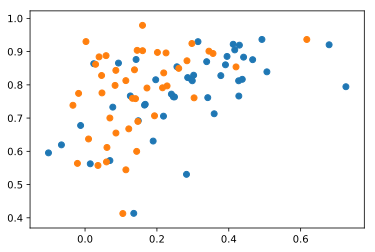

In [105]:
colors = [col2 if is_pat else col1 for is_pat in y]
plt.scatter(df_all_feats['env_alpha_f3_t5'], df_all_feats['coh_alpha_t4_f8'], color=colors)

## Dependency on N features

In [99]:
rows = []
for i in range(len(features_filtered)):
    n_feats = i + 1
    feats = features_filtered[:n_feats]
    X = df_all_feats[feats].fillna(0).values
    y = df_all_feats['target'].values
    model = LRModel()
    d = run_exper(X, y, model)
    d['n_features'] = n_feats
    rows.append(d)
df_dep_on_n_feats = pd.DataFrame(rows)

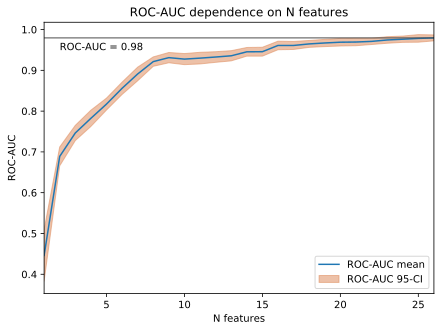

In [104]:
plt.figure(figsize=[7, 5])
pal = sns.color_palette('deep')

plt.plot(df_dep_on_n_feats['n_features'], df_dep_on_n_feats['roc_auc_mean'], label='ROC-AUC mean')

lb = df_dep_on_n_feats['roc_auc_mean'] - 1.96 * df_dep_on_n_feats['roc_auc_std'] 
ub = df_dep_on_n_feats['roc_auc_mean'] + 1.96 * df_dep_on_n_feats['roc_auc_std']
ub = np.where(ub > 1, 1, ub)
plt.fill_between(df_dep_on_n_feats['n_features'], lb, ub, color=pal[1], alpha=0.5, label='ROC-AUC 95-CI')

max_val = df_dep_on_n_feats.iloc[-1]['roc_auc_mean']

plt.axhline(y=max_val, xmin=0, xmax=len(df_dep_on_n_feats), linewidth=1, color='0.3')
plt.text(2, max_val - 0.03, 'ROC-AUC = {:.2f}'.format(max_val))

plt.legend(loc=4)
plt.xlim([1, len(features_filtered)])
plt.xlabel('N features')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC dependence on N features')

plt.savefig('roc_auc_vs_n_feats.png', transparent=True, dpi=150)

## Sample size dependency

In [74]:
from tqdm import tqdm_notebook

In [75]:
rows = []

X = df_all_feats[features_filtered].fillna(0).values
y = df_all_feats['target'].values
n_total = X.shape[0]

custom_model = LRModel()

for n in tqdm_notebook(range(30, n_total)):
    for iter_idx in range(100):
        random_state = np.random.choice(np.arange(1000))
        idx = np.random.choice(np.arange(89), size=n, replace=False)
        X_cur = X[idx]
        y_cur = y[idx]
        random_state = np.random.choice(np.arange(10000))
        custom_model.run_cv(X_cur, y_cur, random_state=random_state)
        roc_auc = custom_model.get_roc_auc()
        acc = custom_model.get_accuracy()
        d = {
            'n': n,
            'iter_idx': iter_idx,
            'roc_auc': roc_auc,
            'acc': acc
        }
        rows.append(d)

res_df_stage = pd.DataFrame(rows)

res_df_stage_21 = res_df_stage.groupby(
    'n')['roc_auc', 'acc'].mean(
).rename(
    columns={
        'roc_auc': 'roc_auc_mean',
        'acc': 'acc_mean',
})

res_df_stage_22 = res_df_stage.groupby(
    'n')['roc_auc', 'acc'].std(
).rename(
    columns={
        'roc_auc': 'roc_auc_std',
        'acc': 'acc_std',
})

df_sample_size_dep = pd.concat([res_df_stage_21, res_df_stage_22], axis=1)
df_sample_size_dep.reset_index(inplace=True)

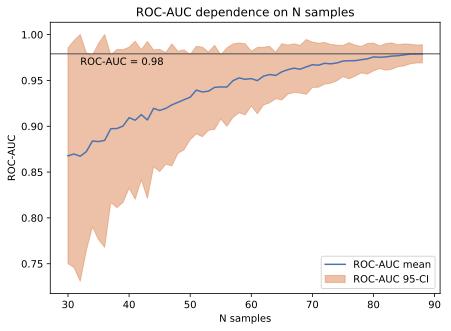

In [76]:
plt.figure(figsize=[7, 5])
pal = sns.color_palette('deep')

plt.plot(df_sample_size_dep['n'], df_sample_size_dep['roc_auc_mean'], label='ROC-AUC mean', color=pal[0])

lb = df_sample_size_dep['roc_auc_mean'] - 1.96 * df_sample_size_dep['roc_auc_std'] 
ub = df_sample_size_dep['roc_auc_mean'] + 1.96 * df_sample_size_dep['roc_auc_std'] 
ub = np.where(ub > 1, 1, ub)
plt.fill_between(df_sample_size_dep['n'], lb, ub, color=pal[1], alpha=0.5, label='ROC-AUC 95-CI')

max_val = df_sample_size_dep.iloc[-1]['roc_auc_mean']

plt.axhline(y=max_val, xmin=0, xmax=len(df_sample_size_dep), linewidth=1, color='0.3')
plt.text(32, max_val - 0.012, 'ROC-AUC = {:.2f}'.format(max_val))

plt.legend(loc=4)
# plt.xlim([1, len(features_filtered)])
plt.xlabel('N samples')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC dependence on N samples')

plt.savefig('roc_auc_vs_n_samples.png', transparent=True, dpi=150)

## Feature Importance

In [69]:
import matplotlib.patches as mpatches

In [93]:
X = df_all_feats[features_filtered].fillna(0).values
y = df_all_feats['target'].values

X_sc = StandardScaler().fit_transform(X)
lr = LogisticRegression(solver='liblinear')
lr.fit(X_sc, y)
weights = [(f, w) for f, w in zip(features_filtered, lr.coef_[0])]
weights = sorted(weights, key=operator.itemgetter(1))
features = list(list(zip(*weights))[0])[::-1]


In [94]:
weights_df = pd.DataFrame(weights, columns=['feature', 'weight'])

In [97]:
weights_df['weight_abs'] = weights_df['weight'].abs()
weights_df['is_positive'] = (weights_df['weight'] > 0).astype(int)
weights_df.sort_values('weight_abs', inplace=True)

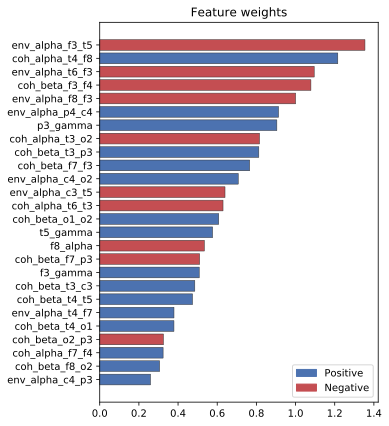

In [98]:
plt.figure(figsize=[5, 7])
idx = np.arange(len(weights_df))

pal = sns.color_palette('deep')
color_dict = {
    0: pal[3],
    1: pal[0]
}
color = [color_dict[is_positive] for is_positive in weights_df['is_positive']]

positive = mpatches.Patch(color=color_dict[1], label='Positive')
negative = mpatches.Patch(color=color_dict[0], label='Negative')
plt.legend(handles=[positive, negative])

plt.barh(idx, weights_df['weight_abs'], color=color, linewidth=0.5, edgecolor='.2')
plt.yticks(idx, weights_df['feature']);
plt.title('Feature weights')

plt.savefig('feature_weights.png', transparent=True, dpi=150, bbox_inches='tight')

In [106]:
df_features = df_all_feats[features_filtered + ['fn']].copy()
df_features[features_filtered] = StandardScaler().fit_transform(df_features[features_filtered])

df_features.set_index('fn', inplace=True)

df_features = df_features.stack().reset_index().rename(columns={'level_1': 'feature', 0: 'value'})
df_features = df_features.merge(df_all_feats[['fn', 'target']], on='fn')

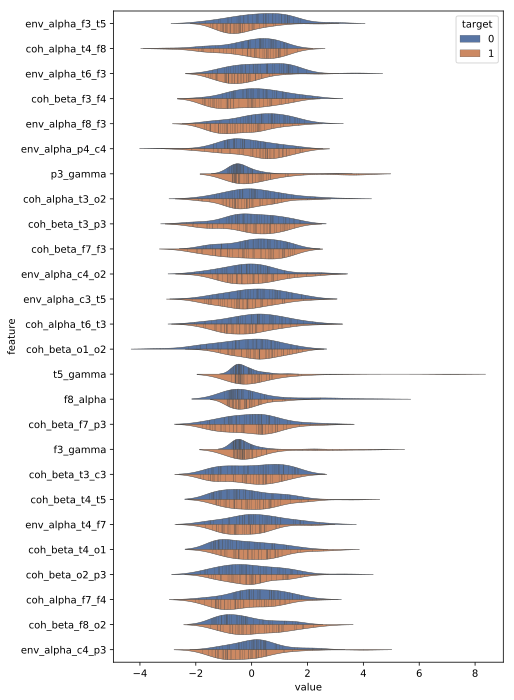

In [107]:
plt.figure(figsize=[7, 12])
sns.violinplot(x="value", y="feature", hue="target",
               data=df_features[df_features['feature'].isin(features_filtered)], 
               order=weights_df['feature'][::-1],
               linewidth=0.5,
               palette="deep", split=True, inner='stick', orient='h', scale='width')
plt.savefig('feature_violins.png', transparent=True, dpi=150, bbox_inches='tight')

In [ ]:
weights_df